In [ ]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap

import optax
import matplotlib.pyplot as plt

from data import dataset_LLT
from conj_grad import ConjGrad, apply_LLT, apply_Jacobi
from loss import LLT_loss
from model import MessagePassing, FullyConnectedNet, PrecNet
from train import train, compute_loss_LLT
from utils import params_count

# Make dataset

In [3]:
grid = 32
N_samples = 32

In [4]:
A_train, b_train, u_exact_train, bi_edges_train, nodes_train, edges_train, receivers_train, senders_train = dataset_LLT(grid, N_samples, seed=42)
A_test, b_test, u_exact_test, bi_edges_test, nodes_test, edges_test, receivers_test, senders_test = dataset_LLT(grid, N_samples=10, seed=43)

2024-03-18 09:48:39.382774: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
# Normalize linear system in form: norm**(-1) * A @ u = f * norm**(-1)

norm_train = jnp.linalg.norm(edges_train, axis=1)
norm_test = jnp.linalg.norm(edges_test, axis=1)

edges_train = jnp.einsum('bi, b -> bi', edges_train, 1./norm_train)
nodes_train = jnp.einsum('bi, b -> bi', nodes_train, 1./norm_train)
b_train = jnp.einsum('bi, b -> bi', b_train, 1./norm_train)
A_train = A_train / norm_train[..., None, None]

edges_test = jnp.einsum('bi, b -> bi', edges_test, 1./norm_test)
nodes_test = jnp.einsum('bi, b -> bi', nodes_test, 1./norm_test)
b_test = jnp.einsum('bi, b -> bi', b_test, 1./norm_test)
A_test = A_test / norm_test[..., None, None]

# Train model

In [6]:
seed = 42
NodeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed))
EdgeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed))
EdgeDecoder = FullyConnectedNet(features=[16, 16, 1], N_layers=2, key=random.PRNGKey(seed))

mp_rounds = 5
MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed)),    
    update_node_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed)),
    mp_rounds=mp_rounds
)

model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)
print(f'Parameter number: {params_count(model)}')

Parameter number: 3009


Minimum element in initial L: 0.00000, maximum element in initla L: 0.28330785036087036
Initial loss value:  197255.53125


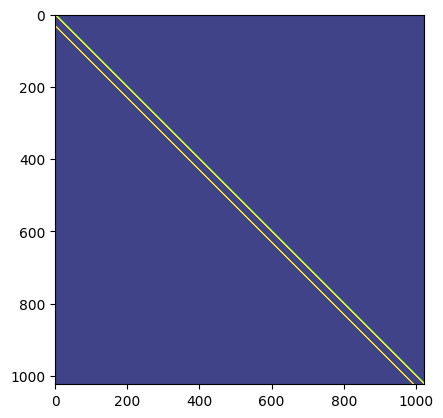

In [7]:
L_before_train = vmap(model, in_axes=(0, 0, 0, 0, 0), out_axes=(0))(nodes_train, edges_train, receivers_train, senders_train, bi_edges_train)
print(f'Minimum element in initial L: {jnp.abs(L_before_train[0, ...]).min().item():.5f}, maximum element in initla L: {jnp.abs(L_before_train[0, ...]).max().item()}')
print(f'Initial loss value: {LLT_loss(L_before_train[0, ...], u_exact_train[0, ...], b_train[0, ...]).item(): .5f}')
plt.imshow(L_before_train[0, :, :], vmin=A_train.data.min().item(), vmax=A_train.data.max().item());

In [8]:
lr = 1e-3
# start, stop, step = 300, 1001, 300
# decay_size = 1e-1
# lr = optax.piecewise_constant_schedule(
#     lr,
#     {k: v for k, v in zip(jnp.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
# )

In [9]:
X_train = (nodes_train, edges_train, receivers_train, senders_train, bi_edges_train, u_exact_train, b_train, A_train)
X_test = (nodes_test, edges_test, receivers_test, senders_test, bi_edges_test, u_exact_test, b_test, A_test)
data = (X_train, X_test, jnp.array([1]), jnp.array([1]))

train_config = {'optimizer': optax.adam,
                'lr': lr,
                'optim_params': {},#{'weight_decay': 1e-8}, 
                'epoch_num': 500}
model, losses = train(model, data, train_config, compute_loss_LLT)

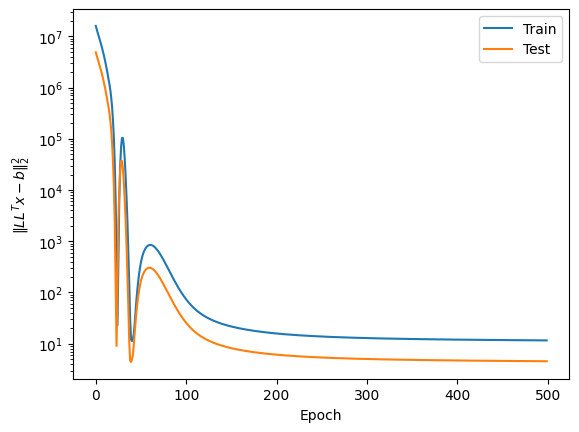

In [10]:
plt.plot(range(len(losses[0])), losses[0], label='Train')
plt.plot(range(len(losses[0])), losses[1], label='Test')
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('$\|LL^Tx - b\|_2^2$');

# Check preconditioner

In [11]:
L = vmap(model, in_axes=(0, 0, 0, 0, 0), out_axes=(0))(nodes_train, edges_train, receivers_train, senders_train, bi_edges_train)

In [53]:
print("Max and min of A's diagonal")
round(A_train.todense()[0, ...].diagonal().min().item(), 5), round(A_train.todense()[0, ...].diagonal().max().item(), 5)

Max and min of A's diagonal


(0.02804, 0.02804)

In [52]:
print("Max and min of LL^T's diagonal")
round((L[0, ...] @ L[0, ...].T).diagonal().min().item(), 5), round((L[0, ...] @ L[0, ...].T).diagonal().max().item(), 5)

Max and min of LL^T's diagonal


(0.01885, 0.02741)

Minimum change in diagonal: 0.000633
Maximum change in diagonal: 0.009193


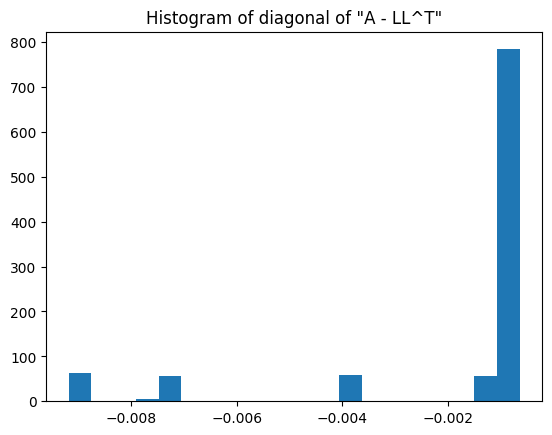

In [60]:
print(f'Minimum change in diagonal: {jnp.abs((L[0, ...] @ L[0, ...].T).diagonal() - A_train.todense()[0, ...].diagonal()).min().item():.6f}')
print(f'Maximum change in diagonal: {jnp.abs((L[0, ...] @ L[0, ...].T).diagonal() - A_train.todense()[0, ...].diagonal()).max().item():.6f}')
plt.hist((L[0, ...] @ L[0, ...].T).diagonal() - A_train.todense()[0, ...].diagonal(), bins=20)
plt.title('Histogram of diagonal of "A - LL^T"');

In [12]:
print(f'Condition number of A:      {jnp.linalg.cond(A_train.todense()[0, ...]):.2f}')
print(f'Condition number of L:      {jnp.linalg.cond(L[0, ...]):.2f}')
print(f'Condition number of LL^T:   {jnp.linalg.cond(L[0, ...] @ L[0, ...].T):.2f}')
print(f'Condition number of Jacobi: {jnp.linalg.cond(jnp.diag(jnp.diag(A_train.todense()[0, ...]))):.2f}')

Condition number of A:      440.69
Condition number of L:      28.36
Condition number of LL^T:   804.13
Condition number of Jacobi: 1.00


In [13]:
jnp.square(jnp.linalg.norm(A_train.todense()[0, ...] - L[0, ...] @ L[0, ...].T, ord='fro')).item()

0.06126302108168602

In [14]:
print(f'Minimum element in trained L: {jnp.abs(L[0, ...]).min().item():.5f}\nMaximum element in trained L: {jnp.abs(L[0, ...]).max().item():.5f}')
print(f'Final train loss value:       {LLT_loss(L[0, ...], u_exact_train[0, ...], b_train[0, ...]).item():.5f}', end='\n\n')
a_llt = jnp.square(jnp.linalg.norm(A_train.todense()[0, ...] - L[0, ...] @ L[0, ...].T, ord='fro')).item()
print(f'Squared Frobenius norm of "A-LL^T": {a_llt:.5f}')

Minimum element in trained L: 0.00000
Maximum element in trained L: 0.13728
Final train loss value:       0.19928

Squared Frobenius norm of "A-LL^T": 0.06126


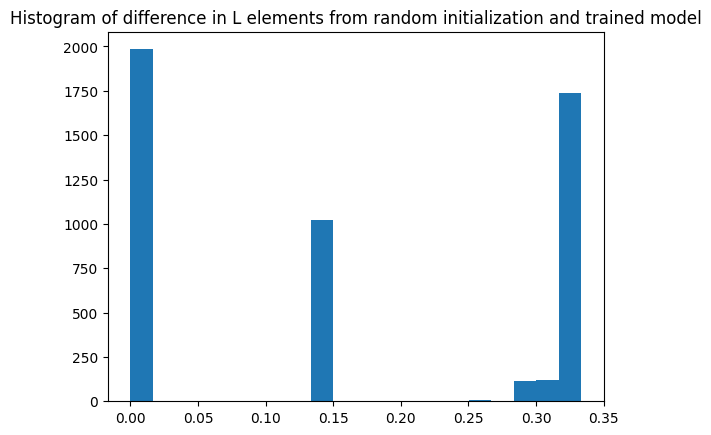

In [15]:
plt.hist((L_before_train - L)[0, senders_train[0, ...], receivers_train[0, ...]], bins=20)
plt.title('Histogram of difference in L elements from random initialization and trained model');

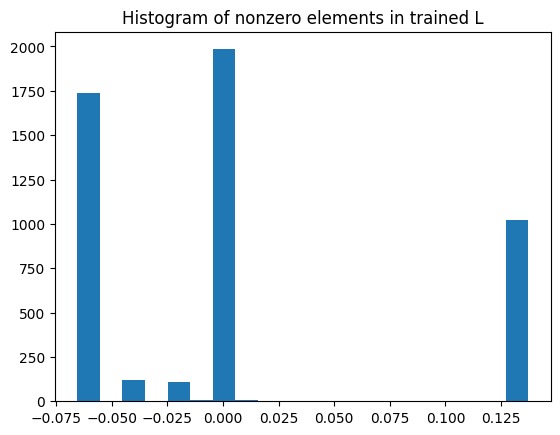

In [16]:
plt.hist(L[0, senders_train[0, ...], receivers_train[0, ...]], bins=20)
plt.title('Histogram of nonzero elements in trained L');

# Apply model to CG

In [17]:
# Data for CG

# data_cg_train = (A_train, b_train, u_exact_train, nodes_train, edges_train, receivers_train, senders_train, bi_edges_train)
data_cg_test = (A_test, b_test, u_exact_test, nodes_test, edges_test, receivers_test, senders_test, bi_edges_test)

In [18]:
# Not preconditioned

# X_I, R_I, _ = ConjGrad(data_cg_train, N_iter=300, model=None, prec_func=None, m_max=None, seed=42)
X_I, R_I, _ = ConjGrad(data_cg_test, N_iter=300, model=None, prec_func=None, m_max=None, seed=42)

In [19]:
# Apply LLT model

# X_LLT, R_LLT, _ = ConjGrad(data_cg_train, N_iter=100, model=model, prec_func=apply_LLT, m_max=None, seed=42)
X_LLT, R_LLT, _ = ConjGrad(data_cg_test, N_iter=300, model=model, prec_func=apply_LLT, m_max=None, seed=42)

In [20]:
# Apply Jacobi prec model

# X_J, R_J, _ = ConjGrad(data_cg_train, N_iter=300, model=model, prec_func=apply_Jacobi, m_max=None, seed=42)
# X_J, R_J, _ = ConjGrad(data_cg_test, N_iter=300, model=model, prec_func=apply_Jacobi, m_max=None, seed=42)

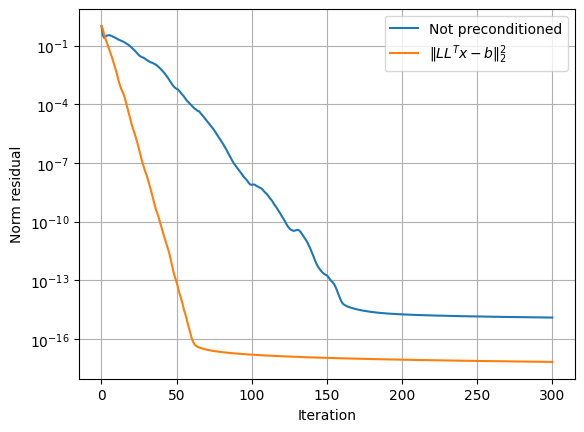

In [21]:
plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="Not preconditioned")
plt.plot(range(R_LLT.shape[-1]), jnp.linalg.norm(R_LLT, axis=1).mean(0), label="$\|LL^Tx - b\|_2^2$")
# plt.plot(range(R_J.shape[-1]), jnp.linalg.norm(R_J, axis=1).mean(0), label="Jacobi")

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log')
plt.grid();

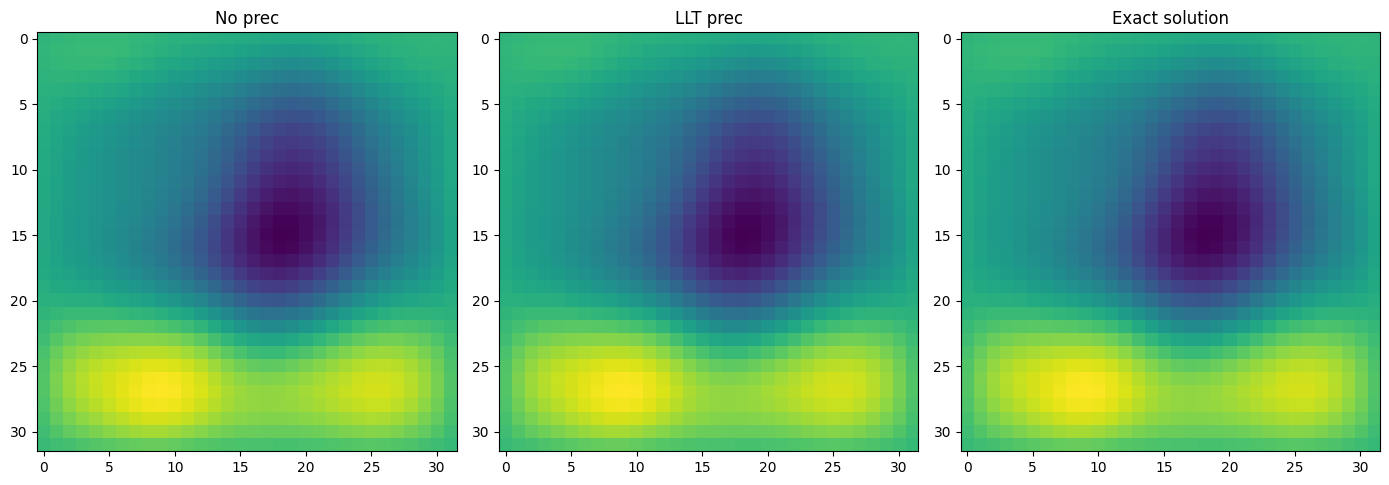

In [22]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :, -1].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :, -1].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('LLT prec')
axes[2].set_title('Exact solution')

plt.tight_layout()

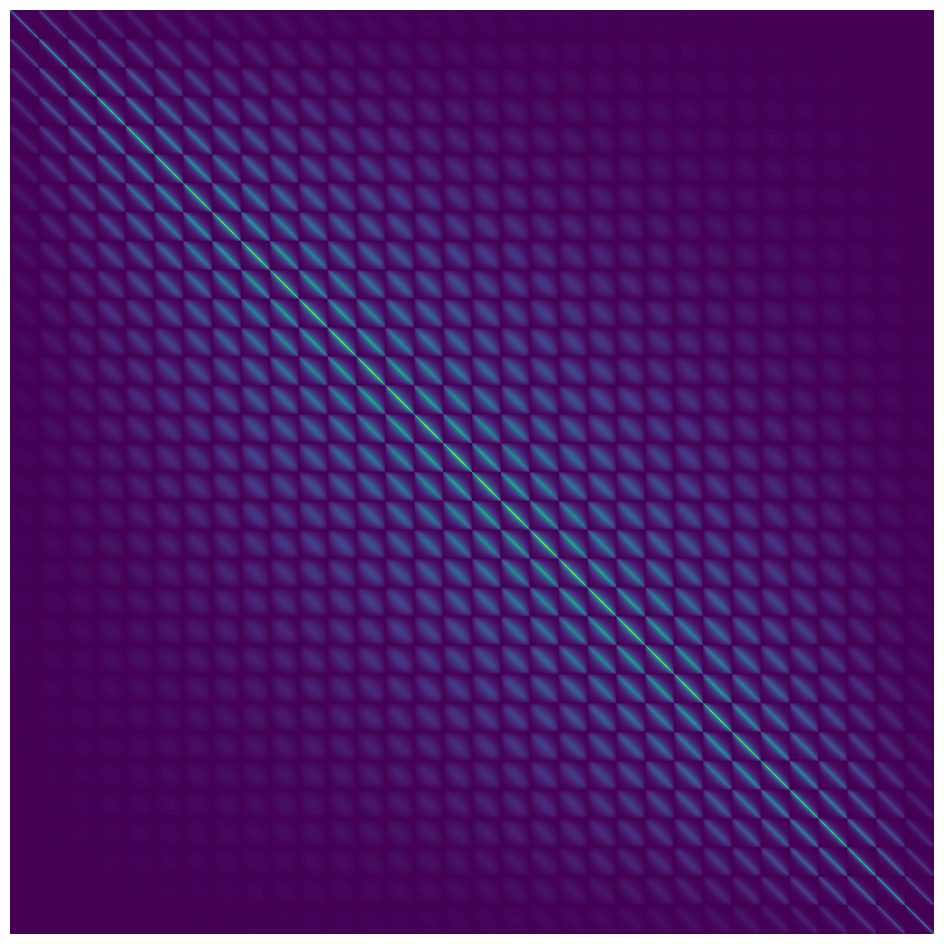

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(jnp.linalg.inv(A_test.todense())[0, ...])
ax.axis(False);